### Analiza Bólu Biodra
Analiza danych z zestawu hp_retro_data, zawierającego 24 atrybuty. Dataset zawiera kolumnę `TRIAGE` zawierającą dycyzję lekarzy, co do dalszego leczenia pacjentów, na podstawie pozostałych danych.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
RANDOM_STATE = 42

In [3]:
df = pd.read_excel('./hp_retro_data.xls',header=0,skiprows=2,sheet_name='Discretized Data (Final)',engine='xlrd')
df = df.drop(columns='NUMBER')
df = df.replace('?', np.nan)
df.head()

,SEX,TEMP,HEART_RATE,AGE,PREV_VISIT,HX_TRAUMA,COMPLAINT_SITE,HX_ILLNESS,GAIT_REPORTED,DURATION,...,GAIT_OBSERVED,PAIN_ROM_HIP,OTHER_PAIN_SITE,PAIN_PALPATION,SWELLING,CURRENT_ILLNESS,PREV_PROBLEMS,WBC,ESR,TRIAGE
0,FEMALE,NaN,GE80_LT120,GE6Y,NaN,NO,HIP,NO,NOT_WT_BEAR,LT24H,...,NaN,YES,NaN,TENDER,NO,NO,NO,NaN,NaN,DISCHARGE
1,FEMALE,LT38,GE120,LT6Y,NaN,NO,LEG,NO,NaN,LT24H,...,NaN,YES,NO,NaN,NaN,NO,NO,NaN,NaN,DISCHARGE
2,MALE,LT38,NaN,GE6Y,NaN,NaN,HIP,NO,NaN,GE7D,...,LIMP,YES,NO,NaN,NO,YES,NaN,NaN,NaN,DISCHARGE
3,MALE,LT38,GE80_LT120,GE6Y,NaN,YES,HIP,NaN,NaN,GE24H_LT7D,...,NORMAL,YES,NaN,NORMAL,NO,NO,NaN,NaN,NaN,DISCHARGE
4,FEMALE,NaN,GE80_LT120,GE6Y,NaN,YES,HIP,NaN,NaN,GE24H_LT7D,...,NOT_WT_BEAR,NaN,LEG,NaN,NO,NaN,NO,NaN,NaN,DISCHARGE


In [4]:
df.value_counts('TRIAGE')

TRIAGE
DISCHARGE         312
XRAY               54
LAB_XRAY_BSCAN     46
Name: count, dtype: int64

### Binaryzacja klas

klasa 1 - LAB_XRAY_BSCAN

klasa 0 - DISCHARGE, XRAY

In [5]:
target = {'DISCHARGE': 0, 'XRAY': 0, 'LAB_XRAY_BSCAN':1}

df['TRIAGE'] = df['TRIAGE'].map(target)
X = df.drop('TRIAGE', axis=1)
y = df['TRIAGE']

Na poniższym wykresie można zobaczyć, że są to dane niezbalansowane tylko 11,2% stanowi klasa pozytywna.

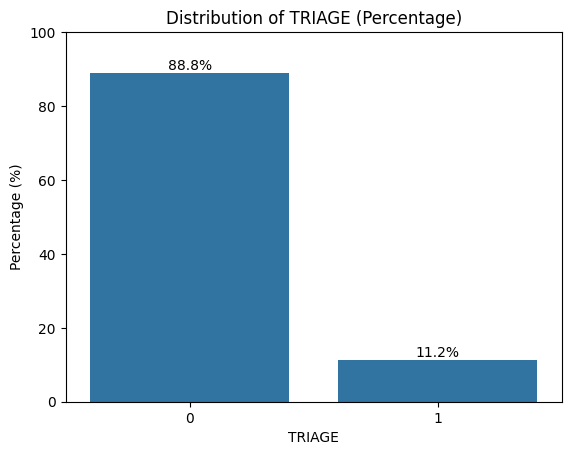

In [ ]:
triage_counts = df['TRIAGE'].value_counts(normalize=True) * 100
triage_counts = triage_counts.reset_index()
triage_counts.columns = ['TRIAGE', 'Percentage']

sns.barplot(x='TRIAGE', y='Percentage', data=triage_counts)
plt.title('Distribution of TRIAGE (Percentage)')
plt.xlabel('TRIAGE')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
for index, row in triage_counts.iterrows():
    plt.text(x=index, y=row['Percentage'] + 1, s=f"{row['Percentage']:.1f}%", ha='center')

plt.show()

Poniżej przedstawione dane pokazują liczbę oraz procentowy udział wartości NaN (brakujących danych) w zbiorze danych. 
Kolumny podzielono na dwie kategorie: - te z 
- wartości brakujące poniżej 50% - zastosowana strategia: imputacja brakujących wartości tymi naczęściej występującymi
- wartości powyżej 50 % - zastosowana strategia: dodanie `NaN` jako osobną kategorię

In [6]:
nan_df = pd.DataFrame(df.isna().sum(), columns=['nan_count']).sort_values(by='nan_count', ascending=False)
nan_df[['nan_count [%]']] = (nan_df[['nan_count']] / len(df) * 100).round(2)
columns_fill_nan = nan_df[(nan_df['nan_count [%]'] > 0) & (nan_df['nan_count [%]'] <= 50)].index
columns_up_to_50_nan = nan_df[nan_df['nan_count [%]'] > 50].index
nan_df

,nan_count,nan_count [%]
HIP_REST,339,82.28
PREV_VISIT,279,67.72
ESR,250,60.68
WBC,241,58.50
SWELLING,150,36.41
GAIT_OBSERVED,122,29.61
PREV_PROBLEMS,122,29.61
PAIN_PALPATION,120,29.13
OTHER_PAIN_SITE,119,28.88
HX_TRAUMA,94,22.82


In [7]:
label_mapping = {}

for column in X.columns:
    if column in columns_fill_nan:
        imputer = SimpleImputer(strategy='most_frequent')
        X[[column]] = imputer.fit_transform(X[[column]])
        
        category = list(X[column].unique())
        encoder = OrdinalEncoder(categories=[category])
        X[[column]] = encoder.fit_transform(X[[column]])
        label_mapping[column] = {label: idx for idx, label in enumerate(encoder.categories_[0])}
    else:

        non_nan_categories = [x for x in X[column].unique() if pd.notna(x)]
        
        X[column] = X[column].fillna('__NaN__')
        
        all_categories = non_nan_categories + ['__NaN__']
        
        encoder = OrdinalEncoder(categories=[all_categories])
        X[[column]] = encoder.fit_transform(X[[column]])
        
        label_mapping[column] = {label: idx for idx, label in enumerate(encoder.categories_[0])}
label_mapping

{'SEX': {'FEMALE': 0, 'MALE': 1, '__NaN__': 2},
 'TEMP': {'LT38': 0, 'GE38': 1},
 'HEART_RATE': {'GE80_LT120': 0, 'GE120': 1, 'GE40_LT80': 2},
 'AGE': {'GE6Y': 0, 'LT6Y': 1, '__NaN__': 2},
 'PREV_VISIT': {'YES': 0, 'NO': 1, '__NaN__': 2},
 'HX_TRAUMA': {'NO': 0, 'YES': 1},
 'COMPLAINT_SITE': {'HIP': 0, 'LEG': 1, 'OTHER': 2, 'BACK': 3},
 'HX_ILLNESS': {'NO': 0, 'YES': 1},
 'GAIT_REPORTED': {'NOT_WT_BEAR': 0, 'LIMP': 1, 'NORMAL': 2},
 'DURATION': {'LT24H': 0, 'GE7D': 1, 'GE24H_LT7D': 2},
 'APPEARANCE': {'WELL_NAD': 0, 'DISTRESS_UNWELL': 1},
 'HIP_REST': {'NORMAL': 0,
  'FLEXED_EXT_ROT': 1,
  'EXT_ROT': 2,
  'FLEXED': 3,
  'INT_ROT': 4,
  '__NaN__': 5},
 'HIP_ROM': {'DECREASED': 0, 'NORMAL': 1},
 'HIP_INT_ROT': {'DECREASED': 0, 'NORMAL': 1},
 'HIP_FLEXION': {'NORMAL': 0, 'DECREASED': 1},
 'GAIT_OBSERVED': {'LIMP': 0, 'NORMAL': 1, 'NOT_WT_BEAR': 2},
 'PAIN_ROM_HIP': {'YES': 0, 'NO': 1},
 'OTHER_PAIN_SITE': {'NO': 0, 'LEG': 1, 'PELVIS': 2, 'BACK': 3, 'OTHER': 4},
 'PAIN_PALPATION': {'TENDER

In [8]:
X

,SEX,TEMP,HEART_RATE,AGE,PREV_VISIT,HX_TRAUMA,COMPLAINT_SITE,HX_ILLNESS,GAIT_REPORTED,DURATION,...,HIP_FLEXION,GAIT_OBSERVED,PAIN_ROM_HIP,OTHER_PAIN_SITE,PAIN_PALPATION,SWELLING,CURRENT_ILLNESS,PREV_PROBLEMS,WBC,ESR
0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
1,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0
2,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,3.0
3,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0
4,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,...,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
408,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
409,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,3.0
410,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Klasyfikator Bazowy 
Jako podstawowy klasyfikator zastosowano Regresję logistyczną

In [ ]:
baseline_clf = LogisticRegression(random_state=RANDOM_STATE)
baseline_clf.fit(X, y)

LogisticRegression(random_state=42)

## Klasyfikator docelowy

Klasyfikatorem docelowym jest `XGBClassifier()` oparty o algorytm XGBoost. Zastosowano również technika nadpróbkowania klas mniejszościowych `SMOTE`, stosowaną przy danych niezbalansowanych oraz standaryzację cech (`StandardScaler()`)
Konfiguracja potoku przetwarzania:

Optymalizacja hiperparametrów:

- Liczba estymatorów (drzew): 50, 100, 200, 300
- Maksymalna głębokość drzewa: 3, 5, 7
- Współczynnik uczenia: 0.01, 0.1
- Waga klas (bilansowanie): 1, 2, 3

Za pomocą `GridSearchCV` klasyfikator przeszukuje siatkę parametrów i optymalizuje pod kątem metryki `average_precision` odpowiedniej dla danych niezbalansowanych

In [ ]:
X = np.array(X)
target_configs = {
    'pipeline': [
        ('scaler', StandardScaler()),
        ('sampler', SMOTE(random_state=RANDOM_STATE)),
        ('estimator', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss'))
    ],
    'params': {
        'estimator__n_estimators': [50, 100, 200, 300],
        'estimator__max_depth': [3, 5, 7],
        'estimator__learning_rate': [0.01, 0.1],
        'estimator__subsample': [0.8, 1.0],
        'estimator__scale_pos_weight': [1, 2, 3],
    }
}

target_pipeline = Pipeline(target_configs['pipeline'])
target_clf = GridSearchCV(
    target_pipeline, 
    target_configs['params'], 
    cv=3,
    scoring='average_precision',
    n_jobs=-1
)

In [72]:
def calculate_risk_metrics(y_test, decisions, grey_zone_mask):
    mask = ~grey_zone_mask
    y_test_grey = y_test[mask]
    decisions_grey = decisions[mask]
    tp = np.sum((decisions_grey == 1) & (y_test_grey == 1))
    fn = np.sum((decisions_grey == 0) & (y_test_grey == 1))
    fp = np.sum((decisions_grey == 1) & (y_test_grey == 0))
    tn = np.sum((decisions_grey == 0) & (y_test_grey == 0))
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0
    fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
    return fpr, fnr

In [ ]:
def run_experiment(clf, X, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)
    result = {
        'auroc': [],
        'auprc': [],
        'fpr': [],
        'fnr': [],
        'pct_negative': [],
        'pct_positive': [],
        'pct_grey_zone': []
    }

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)
    
        y_proba = clf.predict_proba(X_test)[:, 1]
        train_proba = clf.predict_proba(X_train)[:, 1]
        
        # Calculate AUROC and AUPRC
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        auroc = auc(fpr, tpr)
        auprc = auc(recall, precision)
            
        train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba)   

        sensitivity_threshold = 0.99
        sensitivity_mask = train_tpr >= sensitivity_threshold

        if np.any(sensitivity_mask):
            sensitivity_99_idx = np.where(sensitivity_mask)[0][0]
            medium_risk_threshold = train_thresholds[sensitivity_99_idx]
        else:
            medium_risk_threshold = None  

        specificity_threshold = 0.90
        specificity_values = 1 - train_fpr
        specificity_mask = specificity_values >= specificity_threshold

        if np.any(specificity_mask):
            specificity_90_idx = np.where(specificity_mask)[0][-1]
            high_risk_threshold = train_thresholds[specificity_90_idx]
        else:
            high_risk_threshold = None 


        decisions = np.full(len(y_proba), -1)
        decisions[y_proba >= high_risk_threshold] = 1
        decisions[y_proba < medium_risk_threshold] = 0

        grey_zone_mask = (y_proba < high_risk_threshold) & (y_proba >= medium_risk_threshold)
    
        fpr_ , fnr_ = calculate_risk_metrics(y_test.values, decisions, grey_zone_mask)
        result['auroc'].append(auroc)
        result['auprc'].append(auprc)
        result['fpr'].append(fpr_)
        result['fnr'].append(fnr_)
        result['pct_negative'].append(np.sum(decisions == 0) / len(decisions))
        result['pct_positive'].append(np.sum(decisions == 1) / len(decisions))
        result['pct_grey_zone'].append(np.sum(grey_zone_mask) / len(decisions))


    return result

In [68]:
baseline_result = run_experiment(baseline_clf, X, y)

In [62]:
target_result = run_experiment(target_clf, X, y)

In [71]:
print("\nResult for baseline classifier (Logistic Regression):")
print(f"AUPRC: {np.mean(baseline_result['auprc']):.4f} ± {np.std(baseline_result['auprc']):.4f}")
print(f"AUROC: {np.mean(baseline_result['auroc']):.4f} ± {np.std(baseline_result['auroc']):.4f}")
print(f"FNR: {np.mean(baseline_result['fnr']):.4f} ± {np.std(baseline_result['fnr']):.4f}")
print(f"FPR: {np.mean(baseline_result['fpr']):.4f} ± {np.std(baseline_result['fpr']):.4f}")
print(f"% classified as negative: {np.mean(baseline_result['pct_negative']):.2f}%")
print(f"% classified as positive: {np.mean(baseline_result['pct_positive']):.2f}%")
print(f"Gray zone (moderate risk): {np.mean(baseline_result['pct_grey_zone']):.2f}%")


print("\nResult for target classifier (XGBoost):")
print(f"AUPRC: {np.mean(target_result['auprc']):.4f} ± {np.std(target_result['auprc']):.4f}")
print(f"AUROC: {np.mean(target_result['auroc']):.4f} ± {np.std(target_result['auroc']):.4f}")
print(f"FNR: {np.mean(target_result['fnr']):.4f} ± {np.std(target_result['fnr']):.4f}")
print(f"FPR: {np.mean(target_result['fpr']):.4f} ± {np.std(target_result['fpr']):.4f}")
print(f"% classified as negative: {np.mean(target_result['pct_negative']):.2f}%")
print(f"% classified as positive: {np.mean(target_result['pct_positive']):.2f}%")
print(f"Gray zone (moderate risk): {np.mean(target_result['pct_grey_zone']):.2f}%")


Result for baseline classifier (Logistic Regression):
AUPRC: 0.6335 ± 0.1191
AUROC: 0.8974 ± 0.0367
FNR: 0.0833 ± 0.0985
FPR: 0.1456 ± 0.0658
% classified as negative: 0.54%
% classified as positive: 0.17%
Gray zone (moderate risk): 0.29%

Result for target classifier (XGBoost):
AUPRC: 0.6438 ± 0.1008
AUROC: 0.9073 ± 0.0454
FNR: 0.0328 ± 0.0680
FPR: 0.3025 ± 0.3526
% classified as negative: 0.51%
% classified as positive: 0.18%
Gray zone (moderate risk): 0.31%


XGBoost osiągnął wyższą wartość AUPRC niż model bazowy, co wskazuje na lepszą zdolność do radzenia sobie z klasami niezbalansowanymi. Krzywa precision-recall jest szczególnie istotna, gdy klasa pozytywna jest rzadka. XGBoost klasyfikuje znacznie więcej przypadków jako niskiego ryzyka (0.81% vs 0.54%), ale za cenę wyższego wskaźnika FNR (przegapia więcej prawdziwie pozytywnych przypadków). XGBoost pozostawia znacznie mniej przypadków w strefie pośredniego ryzyka, co oznacza, że podejmuje bardziej zdecydowane decyzje. Oba modele klasyfikują podobny odsetek przypadków jako wysokiego ryzyka (0.17% vs 0.14%).

XGBoost wykazuje lepszą ogólną skuteczność pod względem AUROC i AUPRC, co sugeruje, że przy odpowiednim dostosowaniu progów może przewyższyć model bazowy we wszystkich aspektach.